<h1 align="center">CSI1006 - MINIPROJECT

<h1 align="center">Title - ID Card Detection Using Computer Vision</h1>

<h1 align="center">Team Members

<h3 align="center">Priyanshi Premkumar - 19MIC0051</h3>
<h3 align="center">Ravuri Yashaswini Tejaswi - 19MIC0052</h3>
<h3 align="center">Aravinth R - 19MIC0053</h3>


# 1. Setup and Get Data
# 1.1 Install Dependencies and Setup

# 1.2 Collect Images Using OpenCV

In [1]:
import os
import time
import uuid
import cv2

In [2]:
IMAGES_PATH = os.path.join('data','images')
number_images = 30

In [10]:
cap = cv2.VideoCapture(1)
for imgnum in range(number_images):
    print('Collecting image {}'.format(imgnum))
    ret, frame = cap.read()
    imgname = os.path.join(IMAGES_PATH,f'{str(uuid.uuid1())}.jpg')
    cv2.imwrite(imgname, frame)
    cv2.imshow('frame', frame)
    time.sleep(0.5)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

# 1.3 Annotate Images with LabelMe

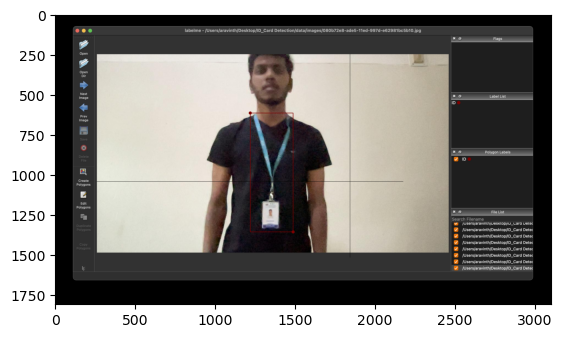

In [24]:
annotate_img=cv2.imread('/Users/aravinth/Desktop/Miniproject/Images/ID.png')
img_rgb = cv2.cvtColor(annotate_img, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)

# 2. Review Dataset and Build Image Loading Function
# 2.1 Import TF and Deps

In [157]:
import tensorflow as tf
import json
import numpy as np
from matplotlib import pyplot as plt

# 2.2 Limit GPU Memory Growth

In [158]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [159]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# 2.3 Load Image into TF Data Pipeline

In [160]:
images = tf.data.Dataset.list_files('data/images/*.jpg',shuffle=False)

In [161]:
images.as_numpy_iterator().next()

b'data/images/0305622c-ade5-11ed-997d-e62981bc5b10.jpg'

In [162]:
def load_image(x): 
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

In [163]:
images = images.map(load_image)

In [164]:
images.as_numpy_iterator().next()

array([[[ 7,  7,  7],
        [ 1,  1,  1],
        [ 5,  5,  5],
        ...,
        [ 5,  5,  5],
        [ 0,  0,  0],
        [ 4,  4,  4]],

       [[ 3,  3,  3],
        [11, 11, 11],
        [ 5,  5,  5],
        ...,
        [ 0,  0,  0],
        [ 1,  1,  1],
        [ 0,  0,  0]],

       [[ 5,  5,  5],
        [ 6,  6,  6],
        [ 2,  2,  2],
        ...,
        [ 0,  0,  0],
        [ 2,  2,  2],
        [ 0,  0,  0]],

       ...,

       [[ 5,  6,  8],
        [ 1,  2,  4],
        [ 4,  5,  7],
        ...,
        [ 0,  0,  0],
        [ 2,  2,  0],
        [ 2,  2,  0]],

       [[ 3,  5,  4],
        [ 5,  7,  6],
        [ 3,  5,  4],
        ...,
        [ 0,  0,  0],
        [ 1,  1,  0],
        [ 3,  3,  1]],

       [[ 1,  3,  2],
        [ 2,  4,  3],
        [ 2,  4,  3],
        ...,
        [ 0,  0,  0],
        [ 4,  4,  2],
        [ 0,  0,  0]]], dtype=uint8)

In [165]:
type(images)

tensorflow.python.data.ops.dataset_ops.MapDataset

# 2.4 View Raw Images with Matplotlib

In [166]:
image_generator = images.batch(4).as_numpy_iterator()

In [169]:
plot_images = image_generator.next()

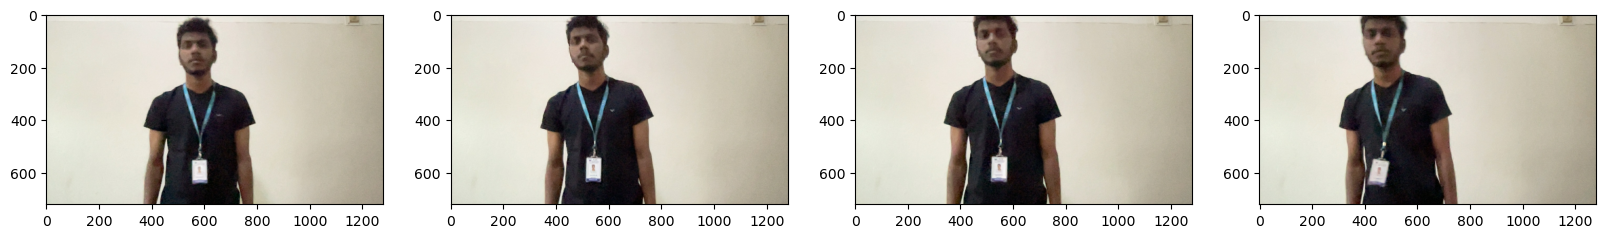

In [170]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, image in enumerate(plot_images):
    ax[idx].imshow(image) 
plt.show()

# 3. Partition Unaugmented Data
# 3.1 MANUALLY SPLT DATA INTO TRAIN TEST AND VAL
# 3.2 Move the Matching Labels

In [171]:
for folder in ['train','test','val']:
    for file in os.listdir(os.path.join('data', folder, 'images')):
        
        filename = file.split('.')[0]+'.json'
        existing_filepath = os.path.join('data','labels', filename)
        if os.path.exists(existing_filepath): 
            new_filepath = os.path.join('data',folder,'labels',filename)
            os.replace(existing_filepath, new_filepath)

# 4. Apply Image Augmentation on Images and Labels using Albumentations
# 4.1 Setup Albumentations Transform Pipeline

In [172]:
import albumentations as alb

In [173]:
augmentor = alb.Compose([alb.RandomCrop(width=450, height=450), 
                         alb.HorizontalFlip(p=0.5), 
                         alb.RandomBrightnessContrast(p=0.2),
                         alb.RandomGamma(p=0.2), 
                         alb.RGBShift(p=0.2), 
                         alb.VerticalFlip(p=0.5)], 
                       bbox_params=alb.BboxParams(format='albumentations', 
                                                  label_fields=['class_labels']))

In [174]:
img=cv2.imread(os.path.join('data', 'train', 'images','0a11ceca-ade5-11ed-997d-e62981bc5b10.jpg'))

In [175]:
img.shape

(720, 1280, 3)

# 4.2 Load a Test Image and Annotation with OpenCV and JSON

In [176]:
with open(os.path.join('data', 'train', 'labels', '0a11ceca-ade5-11ed-997d-e62981bc5b10.json'), 'r') as f:
    label = json.load(f)

In [177]:
label['shapes'][0]['points']

[[575.4651162790698, 218.13953488372096],
 [716.1627906976744, 642.5581395348837]]

# 4.3 Extract Coordinates and Rescale to Match Image Resolution

In [178]:
coords = [0,0,0,0]
coords[0] = label['shapes'][0]['points'][0][0]
coords[1] = label['shapes'][0]['points'][0][1]
coords[2] = label['shapes'][0]['points'][1][0]
coords[3] = label['shapes'][0]['points'][1][1]

In [179]:
coords

[575.4651162790698, 218.13953488372096, 716.1627906976744, 642.5581395348837]

In [180]:
coords = list(np.divide(coords, [1280,720,1280,720]))

In [181]:
coords

[0.4495821220930233,
 0.30297157622739024,
 0.5595021802325582,
 0.8924418604651163]

# 4.4 Apply Augmentations and View Results

In [184]:
augmented = augmentor(image=img, bboxes=[coords], class_labels=['ID'])

In [185]:
augmented['bboxes'][0][2:]

(0.36563307493540054, 1.0)

In [186]:
augmented['bboxes']

[(0.05297157622739024, 0.058087855297157744, 0.36563307493540054, 1.0)]

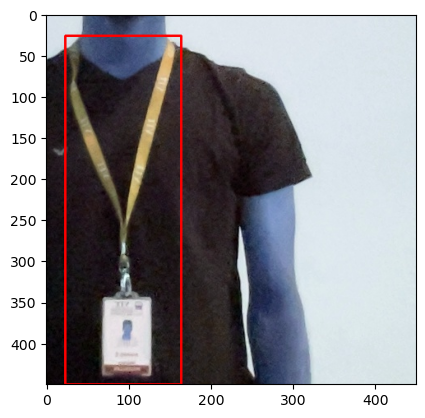

In [187]:
cv2.rectangle(augmented['image'], 
              tuple(np.multiply(augmented['bboxes'][0][:2], [450,450]).astype(int)),
              tuple(np.multiply(augmented['bboxes'][0][2:], [450,450]).astype(int)), 
                    (255,0,0), 2)

plt.imshow(augmented['image'])

# 5. Build and Run Augmentation Pipeline
# 5.1 Run Augmentation Pipeline

In [189]:
for partition in ['train','test','val']: 
    for image in os.listdir(os.path.join('data', partition, 'images')):
        img = cv2.imread(os.path.join('data', partition, 'images', image))

        coords = [0,0,0.00001,0.00001]
        label_path = os.path.join('data', partition, 'labels', f'{image.split(".")[0]}.json')
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label = json.load(f)

            coords[0] = label['shapes'][0]['points'][0][0]
            coords[1] = label['shapes'][0]['points'][0][1]
            coords[2] = label['shapes'][0]['points'][1][0]
            coords[3] = label['shapes'][0]['points'][1][1]
            coords = list(np.divide(coords, [1280,720,1280,720]))

        try: 
            for x in range(60):
                augmented = augmentor(image=img, bboxes=[coords], class_labels=['ID'])
                cv2.imwrite(os.path.join('aug_data', partition, 'images', f'{image.split(".")[0]}.{x}.jpg'), augmented['image'])

                annotation = {}
                annotation['image'] = image

                if os.path.exists(label_path):
                    if len(augmented['bboxes']) == 0: 
                        annotation['bbox'] = [0,0,0,0]
                        annotation['class'] = 0 
                    else: 
                        annotation['bbox'] = augmented['bboxes'][0]
                        annotation['class'] = 1
                else: 
                    annotation['bbox'] = [0,0,0,0]
                    annotation['class'] = 0 


                with open(os.path.join('aug_data', partition, 'labels', f'{image.split(".")[0]}.{x}.json'), 'w') as f:
                    json.dump(annotation, f)

        except Exception as e:
            print(e)

x_max is less than or equal to x_min for bbox [0.545875726744186, 0.31589147286821706, 0.4259629360465116, 0.9198966408268734, 'ID'].
image must be numpy array type
x_max is less than or equal to x_min for bbox [0.564952761627907, 0.32073643410852715, 0.4423146802325581, 0.9037467700258399, 'ID'].
x_max is less than or equal to x_min for bbox [0.532249273255814, 0.2771317829457364, 0.4141533430232558, 0.8956718346253231, 'ID'].
x_max is less than or equal to x_min for bbox [0.44140625, 0.2835917312661499, 0.3187681686046512, 0.9376614987080103, 'ID'].
x_max is less than or equal to x_min for bbox [0.5149890988372092, 0.29651162790697677, 0.3878088662790698, 0.9328165374677002, 'ID'].
x_max is less than or equal to x_min for bbox [0.5622274709302325, 0.29974160206718353, 0.4432231104651162, 0.877906976744186, 'ID'].
x_max is less than or equal to x_min for bbox [0.4532158430232558, 0.2739018087855297, 0.3405704941860465, 0.9247416020671835, 'ID'].
x_max is less than or equal to x_min fo

# 5.2 Load Augmented Images to Tensorflow Dataset

In [190]:
train_images = tf.data.Dataset.list_files('aug_data/train/images/*.jpg', shuffle=False)
train_images = train_images.map(load_image)
train_images = train_images.map(lambda x: tf.image.resize(x, (120,120)))
train_images = train_images.map(lambda x: x/255)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [191]:
test_images = tf.data.Dataset.list_files('aug_data/test/images/*.jpg', shuffle=False)
test_images = test_images.map(load_image)
test_images = test_images.map(lambda x: tf.image.resize(x, (120,120)))
test_images = test_images.map(lambda x: x/255)

In [192]:
val_images = tf.data.Dataset.list_files('aug_data/val/images/*.jpg', shuffle=False)
val_images = val_images.map(load_image)
val_images = val_images.map(lambda x: tf.image.resize(x, (120,120)))
val_images = val_images.map(lambda x: x/255)

In [193]:
train_images.as_numpy_iterator().next()

array([[[0.02634804, 0.02634804, 0.02634804],
        [0.01219363, 0.01219363, 0.01219363],
        [0.02046569, 0.02046569, 0.02046569],
        ...,
        [0.00894608, 0.02463235, 0.02071078],
        [0.00900735, 0.01685049, 0.01292892],
        [0.01789216, 0.02573529, 0.02181373]],

       [[0.01323529, 0.01323529, 0.01323529],
        [0.00876226, 0.00876226, 0.00876226],
        [0.01801471, 0.01801471, 0.01801471],
        ...,
        [0.00643382, 0.02193628, 0.01801471],
        [0.0060049 , 0.01470588, 0.01078431],
        [0.00723039, 0.01378676, 0.0098652 ]],

       [[0.00441176, 0.00441176, 0.00441176],
        [0.00980392, 0.00980392, 0.00980392],
        [0.01519608, 0.01519608, 0.01519608],
        ...,
        [0.01556373, 0.03125   , 0.02732843],
        [0.003125  , 0.01752451, 0.01360294],
        [0.0067402 , 0.01752451, 0.01360294]],

       ...,

       [[0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0

# 6. Prepare Labels
# 6.1 Build Label Loading Function

In [194]:
def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding = "utf-8") as f:
        label = json.load(f)
        
    return [label['class']], label['bbox']

# 6.2 Load Labels to Tensorflow Dataset

In [195]:
train_labels = tf.data.Dataset.list_files('aug_data/train/labels/*.json', shuffle=False)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [196]:
test_labels = tf.data.Dataset.list_files('aug_data/test/labels/*.json', shuffle=False)
test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [197]:
val_labels = tf.data.Dataset.list_files('aug_data/val/labels/*.json', shuffle=False)
val_labels = val_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [198]:
train_labels.as_numpy_iterator().next()

(array([0], dtype=uint8), array([0., 0., 0., 0.], dtype=float16))

# 7. Combine Label and Image Samples
# 7.1 Check Partition Lengths

In [199]:
len(train_images), len(train_labels), len(test_images), len(test_labels), len(val_images), len(val_labels)

(2940, 2940, 600, 600, 540, 540)

# 7.2 Create Final Datasets (Images/Labels)

In [200]:
train = tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(5000)
train = train.batch(8)
train = train.prefetch(4)

In [201]:
test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(1300)
test = test.batch(8)
test = test.prefetch(4)

In [202]:
val = tf.data.Dataset.zip((val_images, val_labels))
val = val.shuffle(1000)
val = val.batch(8)
val = val.prefetch(4)

In [203]:
train.as_numpy_iterator().next()[1]

(array([[1],
        [1],
        [1],
        [0],
        [1],
        [0],
        [0],
        [0]], dtype=uint8),
 array([[0.552  , 0.4055 , 0.88   , 1.     ],
        [0.07776, 0.     , 0.4084 , 0.776  ],
        [0.548  , 0.2092 , 0.8604 , 1.     ],
        [0.     , 0.     , 0.     , 0.     ],
        [0.584  , 0.     , 0.9146 , 0.5566 ],
        [0.     , 0.     , 0.     , 0.     ],
        [0.     , 0.     , 0.     , 0.     ],
        [0.     , 0.     , 0.     , 0.     ]], dtype=float16))

# 7.3 View Images and Annotations

In [204]:
data_samples = train.as_numpy_iterator()

In [221]:
res = data_samples.next()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


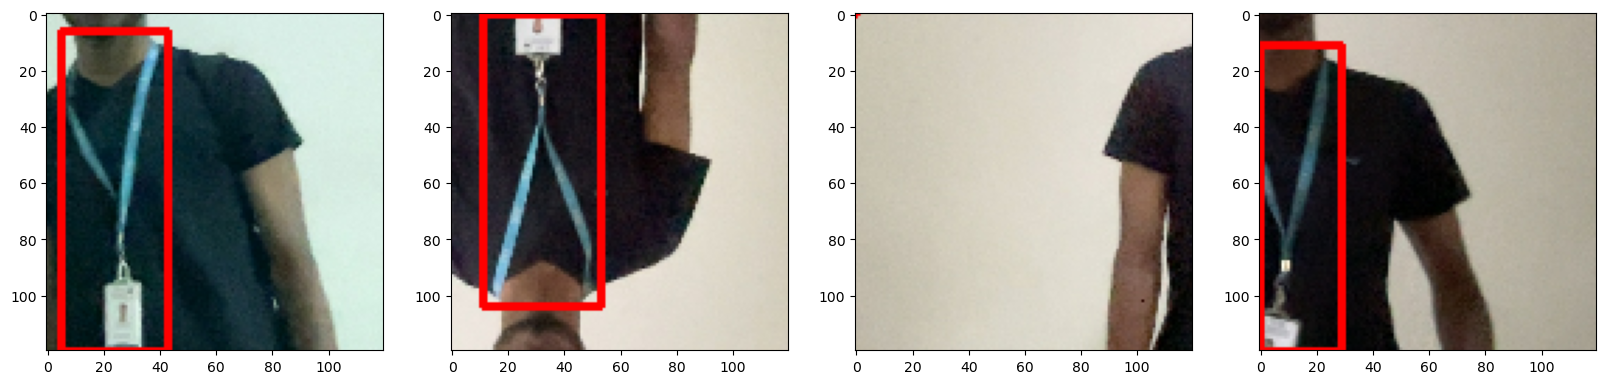

In [222]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = res[0][idx]
    sample_coords = res[1][1][idx]
    
    cv2.rectangle(sample_image, 
                  tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                  tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                        (255,0,0), 2)

    ax[idx].imshow(sample_image)

# 8. Build Deep Learning using the Functional API
# 8.1 Import Layers and Base Network

In [223]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, GlobalMaxPooling2D
from tensorflow.keras.applications import VGG16

# 8.2 Download VGG16

In [224]:
 vgg = VGG16(include_top=False)

In [225]:
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

# 8.3 Build instance of Network

In [226]:
def build_model(): 
    input_layer = Input(shape=(120,120,3))
    
    vgg = VGG16(include_top=False)(input_layer)

    # Classification Model  
    f1 = GlobalMaxPooling2D()(vgg)
    class1 = Dense(2048, activation='relu')(f1)
    class2 = Dense(1, activation='sigmoid')(class1)
    
    # Bounding box model
    f2 = GlobalMaxPooling2D()(vgg)
    regress1 = Dense(2048, activation='relu')(f2)
    regress2 = Dense(4, activation='sigmoid')(regress1)
    
    idtracker = Model(inputs=input_layer, outputs=[class2, regress2])
    return idtracker

# 8.4 Test out Neural Network

In [227]:
idtracker = build_model()

In [229]:
idtracker.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 120, 120, 3  0           []                               
                                )]                                                                
                                                                                                  
 vgg16 (Functional)             (None, None, None,   14714688    ['input_2[0][0]']                
                                512)                                                              
                                                                                                  
 global_max_pooling2d (GlobalMa  (None, 512)         0           ['vgg16[0][0]']                  
 xPooling2D)                                                                                  

In [230]:
X, y = train.as_numpy_iterator().next()

In [231]:
X.shape

(8, 120, 120, 3)

In [233]:
classes, coords = idtracker.predict(X)

1/1 [==============================] - 0s 205ms/step


2023-02-16 17:07:56.500671: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


In [234]:
classes, coords

(array([[0.47387385],
        [0.52359414],
        [0.6311839 ],
        [0.5829804 ],
        [0.56120694],
        [0.50876296],
        [0.5014507 ],
        [0.5492403 ]], dtype=float32),
 array([[0.4732469 , 0.45401382, 0.6442075 , 0.60013914],
        [0.5206934 , 0.49577582, 0.4824873 , 0.57968414],
        [0.6810881 , 0.43280223, 0.6099926 , 0.5199599 ],
        [0.5668997 , 0.503407  , 0.50125283, 0.5592724 ],
        [0.5679837 , 0.4744443 , 0.53438044, 0.5965029 ],
        [0.53189415, 0.5336533 , 0.6341564 , 0.6096969 ],
        [0.543838  , 0.49895754, 0.6325103 , 0.5015194 ],
        [0.51200676, 0.5177553 , 0.6102965 , 0.5495139 ]], dtype=float32))

# 9. Define Losses and Optimizers
# 9.1 Define Optimizer and LR

In [235]:
batches_per_epoch = len(train)
lr_decay = (1./0.75 -1)/batches_per_epoch

In [236]:
opt = tf.keras.optimizers.legacy.Adam(learning_rate=0.0001, decay=lr_decay)

# 9.2 Create Localization Loss and Classification Loss

In [237]:
def localization_loss(y_true, yhat):            
    delta_coord = tf.reduce_sum(tf.square(y_true[:,:2] - yhat[:,:2]))
                  
    h_true = y_true[:,3] - y_true[:,1] 
    w_true = y_true[:,2] - y_true[:,0] 

    h_pred = yhat[:,3] - yhat[:,1] 
    w_pred = yhat[:,2] - yhat[:,0] 
    
    delta_size = tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true-h_pred))
    
    return delta_coord + delta_size

In [238]:
classloss = tf.keras.losses.BinaryCrossentropy()
regressloss = localization_loss

# 9.3 Test out Loss Metrics

In [239]:
localization_loss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=5.205498>

In [240]:
classloss(y[0], classes)

<tf.Tensor: shape=(), dtype=float32, numpy=0.7015059>

In [241]:
regressloss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=5.205498>

# 10. Train Neural Network
# 10.1 Create Custom Model Class

In [244]:
class IDTracker(Model): 
    def __init__(self, eyetracker,  **kwargs): 
        super().__init__(**kwargs)
        self.model = eyetracker

    def compile(self, opt, classloss, localizationloss, **kwargs):
        super().compile(**kwargs)
        self.closs = classloss
        self.lloss = localizationloss
        self.opt = opt
    
    def train_step(self, batch, **kwargs): 
        
        X, y = batch
        
        with tf.GradientTape() as tape: 
            classes, coords = self.model(X, training=True)
            
            batch_classloss = self.closs(y[0], classes)
            batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
            
            total_loss = batch_localizationloss+0.5*batch_classloss
            
            grad = tape.gradient(total_loss, self.model.trainable_variables)
        
        opt.apply_gradients(zip(grad, self.model.trainable_variables))
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
    
    def test_step(self, batch, **kwargs): 
        X, y = batch
        
        classes, coords = self.model(X, training=False)
        
        batch_classloss = self.closs(y[0], classes)
        batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
        total_loss = batch_localizationloss+0.5*batch_classloss
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
        
    def call(self, X, **kwargs): 
        return self.model(X, **kwargs)

In [245]:
model = IDTracker(idtracker)

In [246]:
model.compile(opt, classloss, regressloss)

# 10.2 Train

In [247]:
logdir='logs'

In [248]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [279]:
hist = model.fit(train, epochs=50, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/50
368/368 [==============================] - 70s 181ms/step - total_loss: 0.0471 - class_loss: 0.0111 - regress_loss: 0.0415 - val_total_loss: 0.0199 - val_class_loss: 0.0187 - val_regress_loss: 0.0106
Epoch 2/50
368/368 [==============================] - 71s 182ms/step - total_loss: 0.0392 - class_loss: 0.0091 - regress_loss: 0.0346 - val_total_loss: 0.3791 - val_class_loss: 0.0063 - val_regress_loss: 0.3760
Epoch 3/50
368/368 [==============================] - 73s 184ms/step - total_loss: 0.0484 - class_loss: 0.0123 - regress_loss: 0.0422 - val_total_loss: 8.2578e-04 - val_class_loss: 3.7049e-04 - val_regress_loss: 6.4053e-04
Epoch 4/50
368/368 [==============================] - 73s 188ms/step - total_loss: 0.0390 - class_loss: 0.0091 - regress_loss: 0.0344 - val_total_loss: 1.2588 - val_class_loss: 1.5063 - val_regress_loss: 0.5057
Epoch 5/50
368/368 [==============================] - 75s 192ms/step - total_loss: 0.0389 - class_loss: 0.0090 - regress_loss: 0.0344 - val_tota

368/368 [==============================] - 76s 196ms/step - total_loss: 0.0090 - class_loss: 0.0019 - regress_loss: 0.0081 - val_total_loss: 0.0026 - val_class_loss: 0.0000e+00 - val_regress_loss: 0.0026
Epoch 40/50
368/368 [==============================] - 77s 200ms/step - total_loss: 0.0087 - class_loss: 0.0018 - regress_loss: 0.0078 - val_total_loss: 0.0209 - val_class_loss: 1.3407e-05 - val_regress_loss: 0.0209
Epoch 41/50
368/368 [==============================] - 75s 193ms/step - total_loss: 0.0087 - class_loss: 0.0018 - regress_loss: 0.0078 - val_total_loss: 0.0147 - val_class_loss: 0.0000e+00 - val_regress_loss: 0.0147
Epoch 42/50
368/368 [==============================] - 76s 197ms/step - total_loss: 0.0087 - class_loss: 0.0018 - regress_loss: 0.0078 - val_total_loss: 3.0033 - val_class_loss: 2.8600 - val_regress_loss: 1.5733
Epoch 43/50
368/368 [==============================] - 75s 194ms/step - total_loss: 0.0088 - class_loss: 0.0018 - regress_loss: 0.0079 - val_total_loss:

# 10.3 Plot Performance

In [280]:
hist.history

{'total_loss': [0.0007834603311493993,
  0.002841586945578456,
  0.0018743326654657722,
  0.0019286243477836251,
  0.0007974280742928386,
  0.012723182328045368,
  0.6162934303283691,
  0.0011258177692070603,
  0.000718188879545778,
  0.0013561039231717587,
  0.0006428807391785085,
  0.00030549929942935705,
  0.0004632554773706943,
  0.00035131757613271475,
  0.00034177774796262383,
  0.00014839887444395572,
  0.0005363192176446319,
  0.0005622878670692444,
  0.000594095850829035,
  0.00044172731577418745,
  0.00027030965429730713,
  0.0004612466145772487,
  0.005594297777861357,
  0.00017422923701815307,
  0.0002901888801716268,
  0.000714132038410753,
  0.0005883453413844109,
  0.00012732432514894754,
  0.0008742382051423192,
  0.0002402427780907601,
  0.0005435985513031483,
  4.519872527453117e-05,
  0.0002869953168556094,
  0.00012740954116452485,
  0.0008893244666978717,
  0.0001616915105842054,
  0.0003665679250843823,
  0.00019474481814540923,
  0.00012014476669719443,
  0.00023

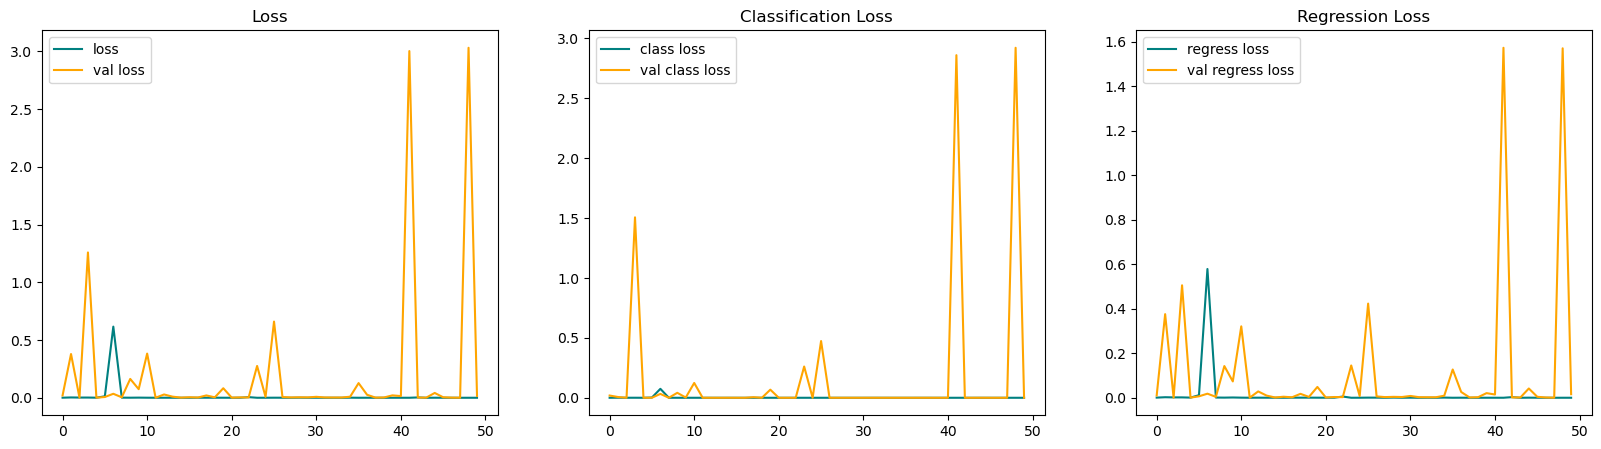

In [281]:
fig, ax = plt.subplots(ncols=3, figsize=(20,5))

ax[0].plot(hist.history['total_loss'], color='teal', label='loss')
ax[0].plot(hist.history['val_total_loss'], color='orange', label='val loss')
ax[0].title.set_text('Loss')
ax[0].legend()

ax[1].plot(hist.history['class_loss'], color='teal', label='class loss')
ax[1].plot(hist.history['val_class_loss'], color='orange', label='val class loss')
ax[1].title.set_text('Classification Loss')
ax[1].legend()

ax[2].plot(hist.history['regress_loss'], color='teal', label='regress loss')
ax[2].plot(hist.history['val_regress_loss'], color='orange', label='val regress loss')
ax[2].title.set_text('Regression Loss')
ax[2].legend()

plt.show()

# 11. Make Predictions
# 11.1 Make Predictions on Test Set

In [282]:
test_data = test.as_numpy_iterator()

In [298]:
test_sample = test_data.next()

In [299]:
yhat = idtracker.predict(test_sample[0])

1/1 [==============================] - 0s 21ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


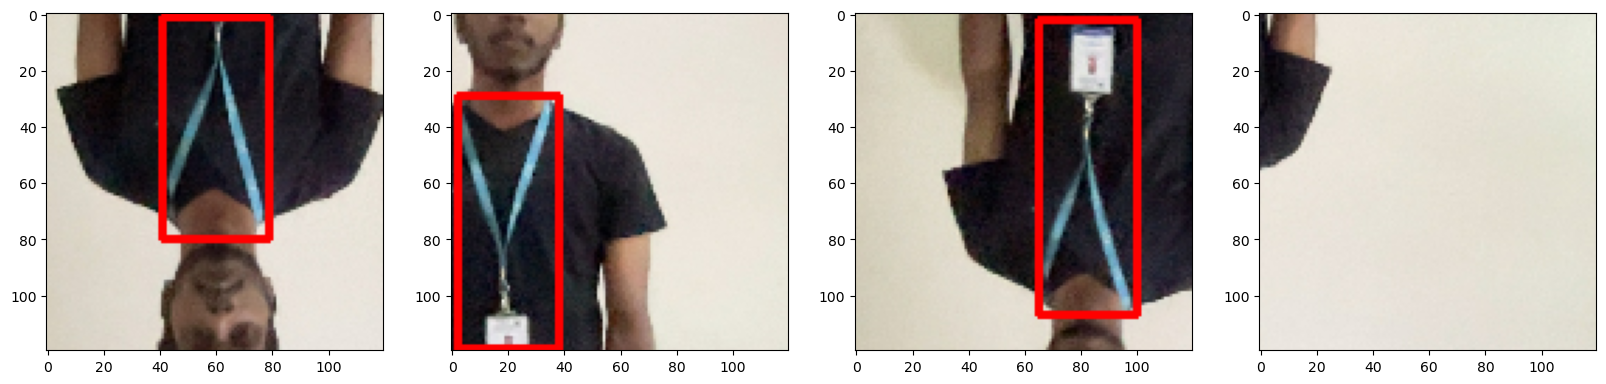

In [300]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = test_sample[0][idx]
    sample_coords = yhat[1][idx]
    
    if yhat[0][idx] > 0.9:
        cv2.rectangle(sample_image, 
                      tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                            (255,0,0), 2)
    
    ax[idx].imshow(sample_image)

# 11.2 Save the Model

In [301]:
from tensorflow.keras.models import load_model

In [302]:
idtracker.save('id_miniproject.h5')

In [303]:
idtracker = load_model('id_miniproject.h5')

# 11.3 Real Time Detection

In [306]:
cap = cv2.VideoCapture(1)
while cap.isOpened():
    _ , frame = cap.read()
    frame=frame[175:175+400,450:450+400,:]
    
    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    resized = tf.image.resize(rgb, (120,120))
    
    yhat = idtracker.predict(np.expand_dims(resized/255,0))
    sample_coords = yhat[1][0]
    
    if yhat[0] > 0.5: 
        # Controls the main rectangle
        cv2.rectangle(frame, 
                      tuple(np.multiply(sample_coords[:2], [450,450]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [450,450]).astype(int)), 
                            (255,0,0), 2)
        # Controls the label rectangle
        cv2.rectangle(frame, 
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int), 
                                    [0,-30])),
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                    [80,0])), 
                            (255,0,0), -1)
        
        # Controls the text rendered
        cv2.putText(frame, 'ID', tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                               [0,-5])),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
    
    cv2.imshow('ID_Detection', frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 11ms/step


# Output

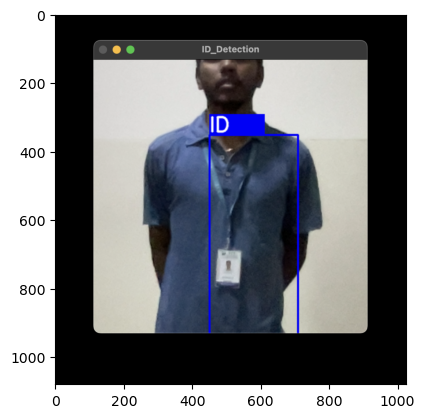

In [308]:
input_img=cv2.imread('/Users/aravinth/Desktop/ID_Card Detection/ID_Card.png')
img_rgb = cv2.cvtColor(input_img, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)